## RIGA 

Implementation of a Random Immigrants GA. This algorithm maintains the diversity level of the population by replacing the worst individuals with new randomly generated solutions.

In [2]:
import time 
import random
import numpy as np
import networkx as nx
from statistics import mean
import matplotlib.pyplot as plt
# Provides heap object 
import heapq

In [14]:
def path_length(p, g):
    return sum(g[i][j]['weight'] for i, j in zip(p, p[1:]))

In [15]:
# Return fitness given path and graph 
def fit(p, g):
    # Zero fitness for invalid path 
    if not nx.is_path(g, p):
        return 0
    
    # Fitness for valid path 
    return path_length(p, g) ** (-1)

In [40]:
# Function to define a single new random path from node s to node r
# in a network supplied as a Networkx graph 
# G: Graph / network as networkx
# s: Start node 
# r: Destination node 
def gen_path(G, s, r):
    path = [s]
    
    current = s
    while current != r: 
        # Neighbours exluding nodes in path 
        neighbours = [n for n in G[current] if n not in path]
        
        # Sometimes, neighbours is empty 
        # In which case, retry 
        if not neighbours:
            return gen_path(G, s, r)
        
        # Select neighbour node with uniform probability  
        nxt = np.random.choice(neighbours) 
        
        # List and visit next node 
        path.append(nxt)
        current = nxt 
        
    return path

In [17]:
# Function to generate a population of n random paths s->r
# G: Graph as networkx
# s: Start node
# r: Destination node
# n: Number of paths / size of population 
def gen_population(G, s, r, n):
    population = [] 
    for i in range(n):
        # Generate a new candidate path
        candidate = gen_path(G, s, r)
        # Generate a new candidate 
        population.append(candidate)
    
    return population

In [18]:
# Perform crossover between two paths s->r
# The two paths must have at least one common element 
# From the set of common elements, one is selected, v 
# The paths are redifined as s -> v, v -> r  
# The path segments are recombined to create two children
# a: The first path
# b: The second path 
def crossover(a, b):
    common = [] 
    for ind_a, i in enumerate(a):
        for ind_b, j in enumerate(b):
            if i == j:
                common.append((ind_a, ind_b))
    
    # Randomly select a one common element to exchange
    target = np.random.choice(len(common))
    
    # Retrieve indexes
    ind_a, ind_b = common[target]
    
    # Create new arrays
    chd_a = a[:ind_a] + b[ind_b:]
    chd_b = b[:ind_b] + a[ind_a:]
    
    return chd_a, chd_b

In [19]:
def mutate(G, path):
    # Select a random element in path, v
    ind = np.random.choice(len(path) - 1)
    
    # Create a new random path from v to destination 
    v = path[ind]
    rnd_path = gen_path(G, v, path[-1])
    
    return path[:ind] + rnd_path

In [20]:
# Compute the fitness value of each hypotheses 
# p: Population
# g: Graph 
# Return: fitness list, maximum fitness value, sum of fitness values 
def evaluate(p, g):
    # Evaluate the fitness of the population 
    fitness = [fit(h, g) for h in p]

    return fitness, max(fitness), sum(fitness), mean(fitness)

In [21]:
# Stochastic universal selection 
#     - Uses a single random value to sample all solutions 
# n: Number of hypotheses to select
# population: Population of hypotheses
# fitness: Fitness array
# ftotal: Sum of fitness values 
# target: Target array to append selected hypotheses 
def stochastic_universal(n, population, fitness, ftotal, target):
    step = ftotal / n                       # Size of selection bins 
    start = random.uniform(0, step)     # Random in range [0, step)
    
    # Each pointer value indicates a selection threshold
    # When the sum of probabilities exceeds a pointer, the current hypotheses is selected 
    pointers = [(start + (i * step)) for i in range(0, n)]
    
    for ptr in pointers:
        ind = 0               # Current index 
        running_sum = 0.0       # Sum of probabilities (fit(h) / total_fitness)
        
        # Until the threshold is exceeded 
        while running_sum < ptr: 
            running_sum += fitness[ind]
            ind += 1 
        
        target.append(population[ind - 1])

In [52]:
# threshold: Number of iterations with unchanged best fitness before exit 
# itr: Maximum number of iterations before quit 
# p: size of population 
# r: fraction of population to be replaced by crossover 
# m: mutation rate 
# s: start node in path 
# d: destination node in path
# g; graph 
def ga(G, threshold, itr, p, r, m, ri, s, d):
    # Store the history of max and mean fitness for generations 
    history = []
    
    # Take starting time 
    start = time.time()
    
    # Generate a random population 
    # Graph; start node; dest node; size of population 
    population = gen_population(G, s, d, p) 
    fitness, fmax, ftotal, favg = evaluate(population, G)
    
    # Track previo
    # Generations 
    count = 0
    unchanged = 0 
    while  (unchanged < threshold) and (count < itr):   
        # Append to training history 
        history.append((fmax, favg, ftotal))
        
        # Create new generation 
        gen = []
        
        # Select ((1 - r) * p) hypotheses to persist into the next generation
        # Hypotheses are selected with fitness proportional probability 
        # Pr(hi) = fit(hi) / sumj(fit(hj))
        num_hypotheses = int((1 - r) * p)
        stochastic_universal(num_hypotheses, population, fitness, ftotal, gen)
        
        # Select (r * p) / 2 pairs of parents for crossover 
        # Parent hypotheses are chosen with fitness proportional probability 
        # Pr(hi) = fit(hi) / sumj(fit(hj))
        parents = [] 
        num_parents = int(r * p) 
        stochastic_universal(num_parents, population, fitness, ftotal, parents)
        
        # Crossover pairs of parents 
        pairs = zip(parents, parents[1:])  # Zip into pairs [1, 2, 3] -> (1, 2), (2, 3)
        for a, b in pairs:
            e, f = crossover(a, b)   # Crossover parents a,b to get children c,d 
            gen.append(e) 
            gen.append(f)
        
        # Choose m percent of new population uniformly to mutate 
        m_size = int(m * p)
        for i in np.random.choice(len(gen), m_size):
            gen[i] = mutate(G, gen[i]) 
        
        
        # *** BEGIN RI SCHEME ***
        
        # Evaluate interim population 'gen'
        (gf, gmax, gtotal, gavg) = evaluate(gen, G)
        
        # Generate ri*p random immigrants 
        n_immigrants = int(ri * p)
        immigrants = gen_population(G, s, d, n_immigrants)
        
        # Replace the ri*p worst candidates with immigrants 
        # O(n log k) to find k smallest elements in array of n 
        #   - Use min heap of size k, compare each element to heap min, i
        #        if smaller then remove max and replace 
        heap = []
        for i in range(n_immigrants):
            # Tuple (fitness, index) and order heap on first element
            heapq.heappush(heap, (-(gf[i]), i)) 
        heapq.heapify(heap)
        
        # Add smaller elements and maintian heap 
        for i in range(n_immigrants, len(gen)):
            if -(gf[i]) < heap[0][0]:
                heap[0] = heap[-1]
                heap.pop()
                heap.append( ((-gf[i]), i) )
                heapq.heapify(heap)
                
        # Replace worst candidates 
        for i in range(n_immigrants):
            ind = heap[i][1]
            gen[ind] = immigrants[i]
        
        # *** END of RI SCHEME *** 

        # Population equal to copy of generation 
        population = list(gen) 
        
        # Evaluate the current population fitness
        _fmax = fmax
        fitness, fmax, ftotal, favg = evaluate(population, G)
        
        # Check if maximum fitness solution has changed 
        if _fmax == fmax:
            unchanged += 1 
        else:
            unchanged = 0 # Reset when max fitness changes 
        
        # Increment generation count
        count += 1 
    
    # Return stats and performance 
    ind = np.argmax(fitness)
    runtime = time.time() - start 
    
    results = {"generations": count, "runtime": runtime,
               "learning_history": history, 
               "solution": population[ind], 
               "length": path_length(population[ind], G), 
               "fitness": fitness[ind]}
    
    return results 

**Test Algorithm**

In [71]:
# Random graph to test
G = nx.erdos_renyi_graph(225, 0.25)

# Assign edge weights 
for (i, j) in G.edges:
    G[i][j]['weight'] = np.random.randint(0, 100)

# GA Hyperparameters 
THRESHOLD = 10          # Iterations where maximum fitness is unchanged to exit
ITERATIONS = 100        # Maximum iterations 
P_SIZE = 100            # Size of population 
M_RATE = 0.025           # Mutation rate (percent of population to mutate)
R_RATE = 0.5            # Percent of population to select as parents
RI = 0.1

results = ga(G, THRESHOLD, ITERATIONS, P_SIZE, R_RATE, M_RATE, RI, 0, 163)

In [72]:
print("Results Small Graph")
print("Solution Path: ", results["solution"])
print("Generations: ", results["generations"])
print("Solution Fitness: ", results["fitness"])
print("Runtime: ", results["runtime"], "seconds")
print("Solution Pathlength: ", results["length"])

Results Small Graph
Solution Path:  [0, 57, 163]
Generations:  10
Solution Fitness:  0.02857142857142857
Runtime:  2.2127370834350586 seconds
Solution Pathlength:  35


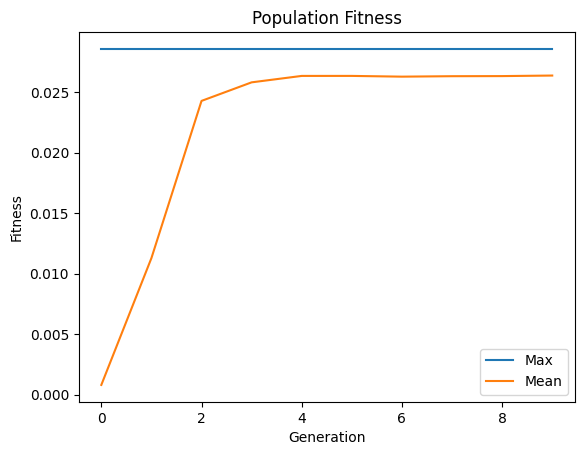

In [73]:
history = results["learning_history"]

# history = [(max, average, total)] * number of generations 
# Plot the training history 
plt.figure()
plt.plot([x for x, y, z in history])
plt.plot([y for x, y, z in history])
plt.title("Population Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(("Max", "Mean"))